#installing dependencies

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sat Jun  8 22:25:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

In [1]:

!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

  Using cached farasapy-0.0.14-py3-none-any.whl (11 kB)
  Using cached PyArabic-0.6.14-py3-none-any.whl (126 kB)
fatal: destination path 'arabert' already exists and is not an empty directory.
  Using cached emoji-1.6.1-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.99
    Uninstalling sentencepiece-0.1.99:
      Successfully uninstalled sentencepiece-0.1.99


Let's get our datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/gp/llmerged_reviews_finalDS.tsv'
df = pd.read_csv(file_path ,sep='\t', encoding='utf-8' )

df.columns


Index(['text', 'label'], dtype='object')

In [ ]:

data= df.dropna()

missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)


Missing Values:
text     0
label    0
dtype: int64


In [ ]:
data.head()

,text,label
0,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...,1
1,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,1
2,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,1
3,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,1
4,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...,1


In [ ]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [ ]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

In [ ]:
train, test= train_test_split(
    data, test_size=0.2, random_state=42
)

label_list = list(data[LABEL_COLUMN].unique())
print(label_list)
print(data[LABEL_COLUMN].value_counts())

data = CustomDataset(
    "full", train, test, label_list
)

all_datasets.append(data)

[1, 0, -1]
label
 1    77128
 0    45705
-1    41941
Name: count, dtype: int64


Start the training procedure

In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [ ]:

dataset_name = 'full'

model_name = 'aubmindlab/bert-base-arabertv02-twitter'

In [ ]:
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


Create and apply preprocessing using the AraBERT processor

In [ ]:
arabic_prep = ArabertPreprocessor(model_name)

selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))

In [ ]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['مرضي . سهولة تسجيل الوصول وكمان الخروج على الساحه وامامه مصلى النساء . المواقف بفلوس ريال لليوم غير تامين كرت الموقف ريال المصاعد قليله بالنسبه لعدد الادوار والسكان خصوصا في الاجازات والمواسم زحام لايوجد مطعم للفندق',
 'بحب الشعر العامى جداا . بس بحب يكون فية وزن . وده اللى افتقدتة إلى حد كبير فى الكتاب ده . لدرجة إنى حسيت فى بعض القصائد إنها مجرد خواطر مش أكتر . لكن ده مايمنعش إنى حبيت جمل كتير فى الكتاب بعيدا عن إنة شعر',
 'جيد . هدوء المكانقربه من المطاعم .',
 'هربت من قبرها جليلة . كيف ؟ . ومع من ؟ . وماهي حقيقة الهروب ؟ . عبده خال ينتقد المجتمع وبعض تصرفاتنا في معالجة الأخطاء التي تزيد من حجم الخطأ وتشعب أضراره . عبده خال لا يكتب عبثا وما فسوق إلا ترجمة لما نعيشه',
 'سلطنة عمان . اعجبني الطاقم كان ودود وحسن الظيافة . المرقص مزعجا',
 'استثنائي . كل شي ممتاز واستقبال ممتاز . لا شي . . بس ينقصهم موظف إستقبال يتحدث بالعربي',
 'مريح وعائلي . مريح وعائلي . طريقة وضع المواقف ا رضيه بالسرداب',
 '" صارت الاسكندرية مدينة من فضة تسرى فيها عروق من ذهب " ما يغيظنى هو الالغام اللى كانت بتتحط 

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [ ]:
tok = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (903 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


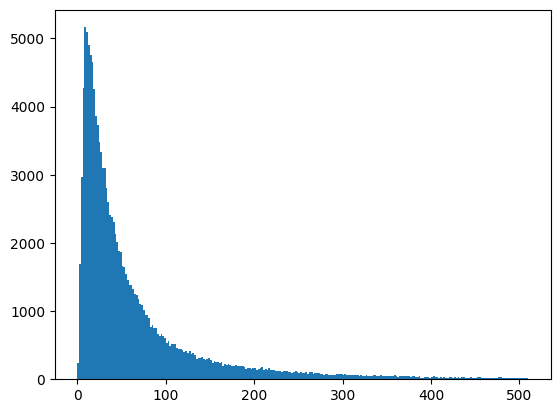

Testing Sentence Lengths: 


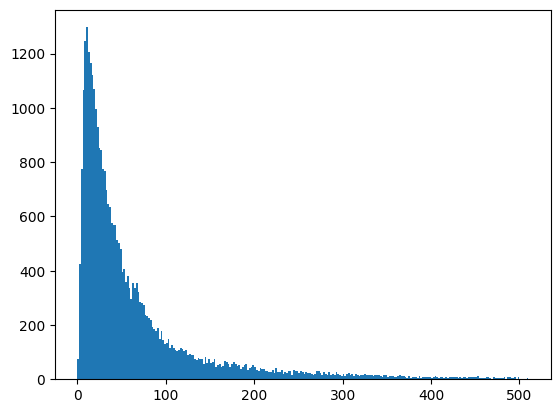

In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,512,2))
plt.show()

print("Testing Sentence Lengths: ")

plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,512,2))
plt.show()

Let's select 500 as our maximum sentence length, and check how many sequences will be truncated

In [ ]:
max_len =  500

In [ ]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  6452
Truncated testing sequences:  6452


Now let's create a classification dataset to load the data

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{1: 0, 0: 1, -1: 2}


Check the dataset output

In [ ]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 37378, 20, 16689, 4031, 3460, 7155, 186, 5275, 323, 3952, 195, 23786, 195, 38231, 3145, 20, 6299, 57779, 493, 1609, 8639, 650, 11153, 307, 26969, 3665, 1609, 766, 1437, 7433, 195, 1245, 52634, 6984, 30803, 22601, 2166, 305, 46144, 5395, 423, 45326, 41367, 14777, 24821, 57055, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Create a function that return a pretrained model ready to do classification

In [ ]:
def model_init():

    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [ ]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'accuracy': acc
  }

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer

In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#start the training
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,0.587300,0.580214,0.721767,0.752784


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,0.587300,0.580214,0.721767,0.752784
1,0.504300,0.568436,0.738007,0.761159


TrainOutput(global_step=8238, training_loss=0.5644020086123139, metrics={'train_runtime': 5052.9193, 'train_samples_per_second': 52.175, 'train_steps_per_second': 1.63, 'total_flos': 1.35467951485734e+16, 'train_loss': 0.5644020086123139, 'epoch': 1.9997572520937008})

# K-fold

In [ ]:
kfold_dataset = selected_dataset.train
kfold_dataset.reset_index(inplace=True,drop=True)

In [ ]:
# this is used later
inv_label_map = { v:k for k, v in label_map.items()}

Defing the number of Stratified kfold splits

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=123
  )

Train using cross validation and save the best model at each fold

In [ ]:
all_results = []
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(kfold_dataset,kfold_dataset['label'])):
  print("**************************Starting Fold Num: ", fold_num," **************************")

  train_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][train]),
                              list(kfold_dataset[LABEL_COLUMN][train]),
                              model_name,
                              max_len,
                              label_map)

  val_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][dev]),
                              list(kfold_dataset[LABEL_COLUMN][dev]),
                              model_name,
                              max_len,
                              label_map)

  training_args = TrainingArguments(
    output_dir= f"./train_{fold_num}",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

  set_seed(training_args.seed)

  trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )
  trainer.model.config.label2id = label_map
  trainer.model.config.id2label = inv_label_map

  trainer.train()

  results = trainer.evaluate()
  all_results.append(results)
  print(results)

  trainer.save_model(f"./train_{fold_num}/best_model")
  val_dataset.tokenizer.save_pretrained(f"./train_{fold_num}/best_model")

  # delete the rest of the checkpoints
  !rm -rf f"./train_{fold_num}/checkpoint-*"

  if results['eval_macro_f1'] > fold_best_f1:
    print('**************************New Best Model Found!**************************')
    fold_best_f1 = results['eval_macro_f1']
    best_fold = fold_num

**************************Starting Fold Num:  0  **************************


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.913708,0.410562,0.577519
1,No log,0.869375,0.428940,0.589147


{'eval_loss': 0.8693745136260986, 'eval_macro_f1': 0.4289396692830169, 'eval_accuracy': 0.5891472868217055, 'eval_runtime': 2.5939, 'eval_samples_per_second': 198.925, 'eval_steps_per_second': 1.928, 'epoch': 1.9393939393939394}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  1  **************************


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.889722,0.484398,0.633721
1,No log,0.842836,0.500144,0.649225


{'eval_loss': 0.8428364992141724, 'eval_macro_f1': 0.50014393697955, 'eval_accuracy': 0.6492248062015504, 'eval_runtime': 2.5565, 'eval_samples_per_second': 201.836, 'eval_steps_per_second': 1.956, 'epoch': 1.9393939393939394}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  2  **************************


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.903224,0.462514,0.610465
1,No log,0.853509,0.480540,0.625969


{'eval_loss': 0.8535090088844299, 'eval_macro_f1': 0.48054035613550944, 'eval_accuracy': 0.625968992248062, 'eval_runtime': 2.6333, 'eval_samples_per_second': 195.948, 'eval_steps_per_second': 1.899, 'epoch': 1.9393939393939394}
**************************Starting Fold Num:  3  **************************


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.900641,0.424858,0.593023
1,No log,0.858165,0.449888,0.604651


{'eval_loss': 0.8581647276878357, 'eval_macro_f1': 0.44988770695111, 'eval_accuracy': 0.6046511627906976, 'eval_runtime': 2.7423, 'eval_samples_per_second': 188.16, 'eval_steps_per_second': 1.823, 'epoch': 1.9393939393939394}
**************************Starting Fold Num:  4  **************************


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.903537,0.440200,0.600000
1,No log,0.864650,0.464990,0.615534


{'eval_loss': 0.8646503686904907, 'eval_macro_f1': 0.46498999685748865, 'eval_accuracy': 0.6155339805825243, 'eval_runtime': 2.6848, 'eval_samples_per_second': 191.819, 'eval_steps_per_second': 1.862, 'epoch': 1.9393939393939394}


In [ ]:
all_results

[{'eval_loss': 0.8693745136260986,
  'eval_macro_f1': 0.4289396692830169,
  'eval_accuracy': 0.5891472868217055,
  'eval_runtime': 2.5939,
  'eval_samples_per_second': 198.925,
  'eval_steps_per_second': 1.928,
  'epoch': 1.9393939393939394},
 {'eval_loss': 0.8428364992141724,
  'eval_macro_f1': 0.50014393697955,
  'eval_accuracy': 0.6492248062015504,
  'eval_runtime': 2.5565,
  'eval_samples_per_second': 201.836,
  'eval_steps_per_second': 1.956,
  'epoch': 1.9393939393939394},
 {'eval_loss': 0.8535090088844299,
  'eval_macro_f1': 0.48054035613550944,
  'eval_accuracy': 0.625968992248062,
  'eval_runtime': 2.6333,
  'eval_samples_per_second': 195.948,
  'eval_steps_per_second': 1.899,
  'epoch': 1.9393939393939394},
 {'eval_loss': 0.8581647276878357,
  'eval_macro_f1': 0.44988770695111,
  'eval_accuracy': 0.6046511627906976,
  'eval_runtime': 2.7423,
  'eval_samples_per_second': 188.16,
  'eval_steps_per_second': 1.823,
  'epoch': 1.9393939393939394},
 {'eval_loss': 0.8646503686904907

In [ ]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

0.464900333241335

## Ensemble all the cross validation models

In [ ]:
from transformers import pipeline
import more_itertools

In [ ]:
inv_label_map = { v:k for k, v in label_map.items()}

In [ ]:


pred_df = selected_dataset.test[DATA_COLUMN]

In [ ]:
cross_val_df = pd.DataFrame([])
for i in range(0,5):
  pipe = pipeline("sentiment-analysis", model=f"train_{i}/best_model", device=0, return_all_scores =True, max_length=max_len, truncation=True)
  preds = []
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference
    preds.extend(pipe(s))
  cross_val_df[f'model_{i}'] = preds

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-41-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-41-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-41-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-41-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
<ipython-input-41-4e292f4ee2d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference


0it [00:00, ?it/s]

In [ ]:
from collections import defaultdict

final_labels = []
final_scores = []
for id, row in cross_val_df.iterrows():
  total_score = defaultdict(lambda: 0)
  for pred in row:
    for cls in pred:
      total_score[cls['label']] += cls['score']

  avg_score = { k: v/ 5 for k, v in total_score.items()}

  final_labels.append(max(avg_score, key=avg_score.get))
  final_scores.append(avg_score[max(avg_score, key=avg_score.get)])

In [ ]:
cross_val_df['preds'] = final_labels
cross_val_df['sentiment_score'] = final_scores

In [ ]:
cross_val_df['preds'].value_counts()

preds
NEG        509
POS        127
NEUTRAL      9
Name: count, dtype: int64

In [ ]:
print(classification_report(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

              precision    recall  f1-score   support

         NEG       0.61      0.93      0.74       336
     NEUTRAL       0.44      0.03      0.05       154
         POS       0.71      0.58      0.64       155

    accuracy                           0.63       645
   macro avg       0.59      0.51      0.47       645
weighted avg       0.59      0.63      0.55       645

